# 5G ENERGY CONSUMPTION MODEL - Estimating the energy consumption in a 5G Base Station

Network operational expenditure (OPEX) already accounts for around 25 percent of the total telecom operator’s cost, and 90 percent of it is spent on large energy bills. More than 70 percent of this energy is estimated to be consumed by the radio access network (RAN), particularly by the base stations (BSs).

#### Dataset
The dataset was provided by (International Telecommunication Union (ITU))[https://www.itu.int/en/Pages/default.aspx]. It has been derived from the original copy and simplified for learning purposes. It includes cell-level traffic statistics of 4G/5G sites collected on different days.

#### Objective & Goal
Thus, the objective is to build and train a ML model to *estimate the energy consumed* by different 5G base stations taking into consideration the impact of various *engineering configurations*, *traffic conditions*, and *energy-saving methods*.

#### Further Resources
To read more on the other objectives: (Read More)[https://challenge.aiforgood.itu.int/match/matchitem/83]

### Steps to follow
1. Import libraries
2. Load dataset
3. Data wrangling & exploration - statistical analysis, data cleaning, understanding, visualization, checking outliers etc
4. Choosing the model
5. Feature engineering & selection
6. Training model
7. Making predictions
8. Evaluation of the model
9. Improving the model

### Step 1: Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
#from sklearn.preprocessing import train_test_split

/Users/macy/.virtual-envs/ml-venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 2: Loading & Exploring the dataset

In [2]:
energy_df = pd.read_csv('datasets/5G_energy_consumption_dataset.csv')
energy_df.head()

,Time,BS,Energy,load,ESMODE,TXpower
0,20230101 010000,B_0,64.275037,0.487936,0.0,7.101719
1,20230101 020000,B_0,55.904335,0.344468,0.0,7.101719
2,20230101 030000,B_0,57.698057,0.193766,0.0,7.101719
3,20230101 040000,B_0,55.156951,0.222383,0.0,7.101719
4,20230101 050000,B_0,56.053812,0.175436,0.0,7.101719


In [3]:
# Transforming the column names to lowercase
energy_df.columns = energy_df.columns.str.lower()

In [4]:
# Checking the shape
energy_df.shape

(92629, 6)

In [5]:
# General information of the data
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92629 entries, 0 to 92628
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     92629 non-null  object 
 1   bs       92629 non-null  object 
 2   energy   92629 non-null  float64
 3   load     92629 non-null  float64
 4   esmode   92629 non-null  float64
 5   txpower  92629 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.2+ MB


In [6]:
# Check for missing values
energy_df.isnull().sum()

time       0
bs         0
energy     0
load       0
esmode     0
txpower    0
dtype: int64

In [7]:
# Check for duplicates
energy_df.duplicated().sum()

np.int64(0)

In [8]:
energy_df.describe(include='all')

,time,bs,energy,load,esmode,txpower
count,92629,92629,92629.000000,92629.000000,92629.000000,92629.000000
unique,168,923,NaN,NaN,NaN,NaN
top,20230102 230000,B_583,NaN,NaN,NaN,NaN
freq,766,130,NaN,NaN,NaN,NaN
mean,NaN,NaN,28.138997,0.244705,0.081361,6.765427
std,NaN,NaN,13.934645,0.234677,0.382317,0.309929
min,NaN,NaN,0.747384,0.000000,0.000000,5.381166
25%,NaN,NaN,18.236173,0.057370,0.000000,6.427504
50%,NaN,NaN,24.065770,0.165550,0.000000,6.875934
75%,NaN,NaN,35.724963,0.363766,0.000000,6.875934


#### 2.1 High level report

1. There are 6 columns in the dataset made up of basic station information, cell-level data, energy consumption data including:
    - Time (Date and time in which the measurement was collected) - cell level and energy consumption
    - Bs(Name of base station) - basic station info.
    - Energy (Energy consumption measurement) - energy consumption data
    - Load (Load of the cell) - cell level data
    - Esmode (Intensity of the activation of different energy-saving modes. It takes value in [0-1]) - cell level data
    - Txpower (Maximum transmit power of the cell. It takes value in [0-1]) - basic station info.
  
2. The bs & time columns data types are all objects, for training our model we need to encode them.
3. There are 92629 rows in the datasets without any duplicates or missing values

#### 2.2 Generate ydata Profile Report

In [9]:
profile = ProfileReport(energy_df, title='5G Base Station Energy Consumption Report')

In [10]:
#profile.to_file(output_file='profile-report.html')

#### 2.3 Feature Engineering

#### 2.3.1 Transforming date type and splitting into the date and time columns

In [11]:
# Transforming time datatype
energy_df.time = pd.to_datetime(energy_df.time)
energy_df.time.dtype

dtype('<M8[ns]')

In [12]:
energy_df['date'] = energy_df.time.dt.date
energy_df['date_time'] = energy_df.time
energy_df['time'] = energy_df.time.dt.time

In [13]:
energy_df.head()

,time,bs,energy,load,esmode,txpower,date,date_time
0,01:00:00,B_0,64.275037,0.487936,0.0,7.101719,2023-01-01,2023-01-01 01:00:00
1,02:00:00,B_0,55.904335,0.344468,0.0,7.101719,2023-01-01,2023-01-01 02:00:00
2,03:00:00,B_0,57.698057,0.193766,0.0,7.101719,2023-01-01,2023-01-01 03:00:00
3,04:00:00,B_0,55.156951,0.222383,0.0,7.101719,2023-01-01,2023-01-01 04:00:00
4,05:00:00,B_0,56.053812,0.175436,0.0,7.101719,2023-01-01,2023-01-01 05:00:00


In [16]:
# Drop our date_time column
energy_df.drop('date_time', axis=1)

,time,bs,energy,load,esmode,txpower,date
0,01:00:00,B_0,64.275037,0.487936,0.0,7.101719,2023-01-01
1,02:00:00,B_0,55.904335,0.344468,0.0,7.101719,2023-01-01
2,03:00:00,B_0,57.698057,0.193766,0.0,7.101719,2023-01-01
3,04:00:00,B_0,55.156951,0.222383,0.0,7.101719,2023-01-01
4,05:00:00,B_0,56.053812,0.175436,0.0,7.101719,2023-01-01
...,...,...,...,...,...,...,...
92624,17:00:00,B_1018,14.648729,0.087538,0.0,7.325859,2023-01-02
92625,18:00:00,B_1018,14.648729,0.082635,0.0,7.325859,2023-01-02
92626,21:00:00,B_1018,13.452915,0.055538,0.0,7.325859,2023-01-02
92627,22:00:00,B_1018,13.602392,0.058077,0.0,7.325859,2023-01-02


#### 2.3.2 Checking and handling outliers in the data

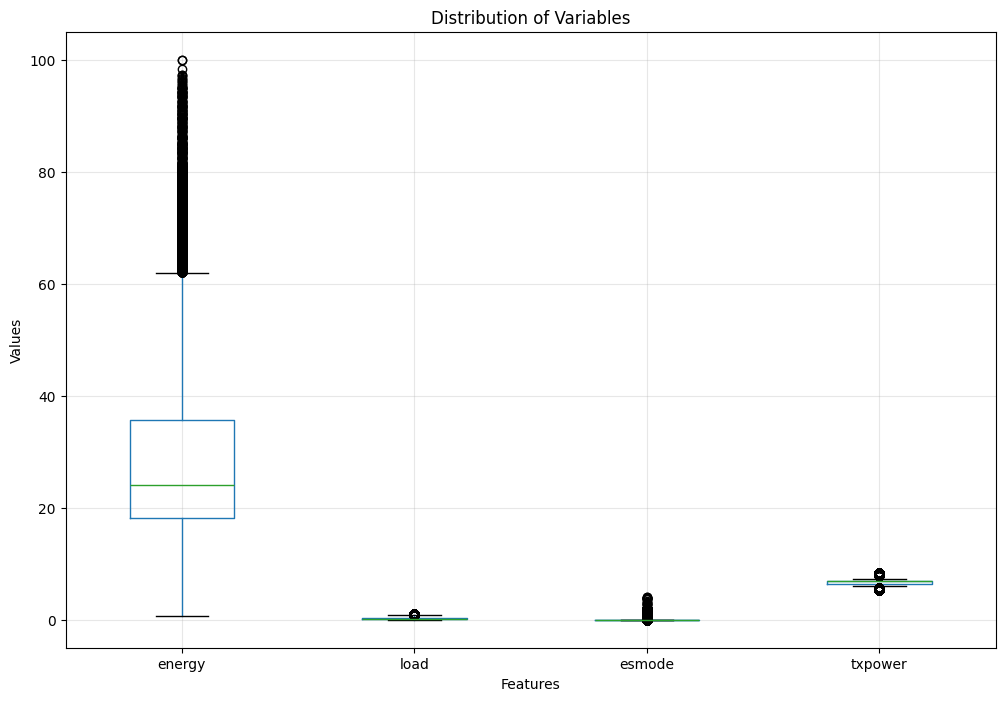

In [36]:
plt.figure(figsize=(12,8))
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Distribution of Variables')
plt.grid(alpha=0.3)
energy_df.boxplot()
plt.show()

From the boxplot, the energy, load, esmode and txpower features have outliers that might make our model inaccurate

https://www.youtube.com/watch?v=CdgvW-Vf_U8&list=TLPQMTcwOTIwMjSleLjs-uqxGQ&index=15&ab_channel=SixSigmaProSMART

#### Use the Inter Quartile Range Approach to handle outliers

In [37]:
def outlier_limits(col):
    Q3, Q1 = np.nanpercentile(col, [75,25])
    inter_quartile_range = Q3 - Q1
    upper_limit = inter_quartile_range + (1.5*inter_quartile_range)
    lower_limit = inter_quartile_range - (1.5*inter_quartile_range)
    return upper_limit, lower_limit

In [45]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92629 entries, 0 to 92628
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       92629 non-null  object        
 1   bs         92629 non-null  object        
 2   energy     60038 non-null  float64       
 3   load       85841 non-null  float64       
 4   esmode     87475 non-null  float64       
 5   txpower    0 non-null      float64       
 6   date       92629 non-null  object        
 7   date_time  92629 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 5.7+ MB


In [49]:
for col in energy_df.columns:
    if energy_df[col].dtype != 'object' and energy_df[col].dtype != 'datetime64[ns]':
        UL, LL = outlier_limits(energy_df[col])
        energy_df[col] = np.where((energy_df[col] > UL) | (energy_df[col] < LL), np.nan, energy_df[col] ) #Where the numerical data is > upper limit and lower < lower limit, replace with null values

In [57]:
energy_df.isnull().sum()

time             0
bs               0
energy       91285
load          9533
esmode        5154
txpower      92629
date             0
date_time        0
dtype: int64

The inter quartile range approach only retains data that's within the 25th (lower) and 75th (upper) quartiles.